# LAN create database

In [0]:
%sql 
drop database if exists u23_2_2 cascade;
create database u23_2_2;
show databases;

namespace
country_club
default
u23_2_2


# Load the data

We need to load data from a file in to a Spark DataFrame.
Each row is an observed customer, and each column contains
attributes of that customer.

[Data from UCI data set repo, hosted by SGI](https://www.sgi.com/tech/mlc/db/churn.all)

    Fields:

    state: discrete.
    account length: numeric.
    area code: numeric.
    phone number: discrete.
    international plan: discrete.
    voice mail plan: discrete.
    number vmail messages: numeric.
    total day minutes: numeric.
    total day calls: numeric.
    total day charge: numeric.
    total eve minutes: numeric.
    total eve calls: numeric.
    total eve charge: numeric.
    total night minutes: numeric.
    total night calls: numeric.
    total night charge: numeric.
    total intl minutes: numeric.
    total intl calls: numeric.
    total intl charge: numeric.
    number customer service calls: numeric.
    churned: discrete.

'Numeric' and 'discrete' do not adequately describe the fundamental differencecs in the attributes.

Area codes are considered numeric, but they a better thought of as a categorical variable. This is because attributes that are really numeric features have a reasonable concept of distance between points. Area codes do not fall into this cateogory. They can have a small distance |area_code_1 - area_code_2| but that distance doesn't correspond to a similarity in area codes.

In [0]:
# original cell that loaded data

from pyspark.sql import SQLContext
from pyspark.sql.types import *

sqlContext = SQLContext(sc)
schema = StructType([ \
    StructField("state", StringType(), True), \
    StructField("account_length", DoubleType(), True), \
    StructField("area_code", StringType(), True), \
    StructField("phone_number", StringType(), True), \
    StructField("intl_plan", StringType(), True), \
    StructField("voice_mail_plan", StringType(), True), \
    StructField("number_vmail_messages", DoubleType(), True), \
    StructField("total_day_minutes", DoubleType(), True), \
    StructField("total_day_calls", DoubleType(), True), \
    StructField("total_day_charge", DoubleType(), True), \
    StructField("total_eve_minutes", DoubleType(), True), \
    StructField("total_eve_calls", DoubleType(), True), \
    StructField("total_eve_charge", DoubleType(), True), \
    StructField("total_night_minutes", DoubleType(), True), \
    StructField("total_night_calls", DoubleType(), True), \
    StructField("total_night_charge", DoubleType(), True), \
    StructField("total_intl_minutes", DoubleType(), True), \
    StructField("total_intl_calls", DoubleType(), True), \
    StructField("total_intl_charge", DoubleType(), True), \
    StructField("number_customer_service_calls", DoubleType(), True), \
    StructField("churned", StringType(), True)])

file_location = "/FileStore/tables/u23_2_2/churn.all"
churn_data = sqlContext.read \
.format('com.databricks.spark.csv') \
.load(file_location, schema = schema)

### LAN investigate

In [0]:
print('type: ', type(churn_data))
print('number rows =', churn_data.count())
churn_data.printSchema()

type: <class 'pyspark.sql.dataframe.DataFrame'>
number rows = 5000
root
-- state: string (nullable = true)
-- account_length: double (nullable = true)
-- area_code: string (nullable = true)
-- phone_number: string (nullable = true)
-- intl_plan: string (nullable = true)
-- voice_mail_plan: string (nullable = true)
-- number_vmail_messages: double (nullable = true)
-- total_day_minutes: double (nullable = true)
-- total_day_calls: double (nullable = true)
-- total_day_charge: double (nullable = true)
-- total_eve_minutes: double (nullable = true)
-- total_eve_calls: double (nullable = true)
-- total_eve_charge: double (nullable = true)
-- total_night_minutes: double (nullable = true)
-- total_night_calls: double (nullable = true)
-- total_night_charge: double (nullable = true)
-- total_intl_minutes: double (nullable = true)
-- total_intl_calls: double (nullable = true)
-- total_intl_charge: double (nullable = true)
-- number_customer_service_calls: double (nullable = true)
-- churned: string (nullable = true)

### LAN create permanent table in database

In [0]:
#permanent_table_name_bookings = "country_club.Bookings"
#bookings_df.write.format("parquet").saveAsTable(permanent_table_name_bookings)

permanent_table_name = "u23_2_2.churn_data"
churn_data.write.format("parquet").saveAsTable(permanent_table_name)

# LAN START HERE AGAIN
### refresh tables and check them

In [0]:
%sql
use u23_2_2;
REFRESH table churn_data;
show tables;

# Basic DataFrame operations

Dataframes essentially allow you to express sql-like statements. We can filter, count, and so on. [DataFrame Operations documentation.](http://spark.apache.org/docs/latest/sql-programming-guide.html#dataframe-operations)

In [0]:
count = churn_data.count()
voice_mail_plans = churn_data.filter(churn_data.voice_mail_plan == " yes").count()

"%d, %d" % (count, voice_mail_plans)

Out[8]: '5000, 1323'

# Exercise: Basic DataFrame operations

How many customers have one or more customer service calls? How many have more than one?

In [0]:
# Your code here

In [0]:
count_have_service_calls = churn_data.filter(churn_data.number_customer_service_calls > 0).count()
print('number customers that have service calls = ', count_have_service_calls)

number customers that have service calls = 3977

In [0]:
count_have_more_than_one_service_calls = churn_data.filter(churn_data.number_customer_service_calls > 1).count()
print('number customers that have >1 service calls = ', count_have_more_than_one_service_calls)

number customers that have >1 service calls = 2191

# Feature Visualization

The data vizualization workflow for large data sets is usually:

* Sample data so it fits in memory on a single machine.
* Examine single variable distributions.
* Examine joint distributions and correlations.
* Look for other types of relationships.

[DataFrame#sample() documentation](http://people.apache.org/~pwendell/spark-releases/spark-1.5.0-rc1-docs/api/python/pyspark.sql.html#pyspark.sql.DataFrame.sample)

In [0]:
sample_data = churn_data.sample(False, 0.5, 83).toPandas()
#sample_data.head()

In [0]:
print(type(sample_data))
print(sample_data.shape)
sample_data.head()

<class 'pandas.core.frame.DataFrame'>
(2495, 21)
Out[14]:

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128.0,415,382-4657,no,yes,25.0,265.1,110.0,45.07,197.4,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1.0,False.
1,NJ,137.0,415,358-1921,no,no,0.0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0.0,False.
2,OH,84.0,408,375-9999,yes,no,0.0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2.0,False.
3,MA,121.0,510,355-9993,no,yes,24.0,218.2,88.0,37.09,348.5,108.0,29.62,212.6,118.0,9.57,7.5,7.0,2.03,3.0,False.
4,RI,74.0,415,344-9403,no,no,0.0,187.7,127.0,31.91,163.4,148.0,13.89,196.0,94.0,8.82,9.1,5.0,2.46,0.0,False.


## DataTypes

![datatypes where continuous and integer are subtypes of numeric data and distinct from the categorical type](slides/datatypes.png)

The type of visualization we do depends on the data type, so lets define what columns have different properties first:

In [0]:
numeric_cols = ["account_length", "number_vmail_messages", "total_day_minutes",
                "total_day_calls", "total_day_charge", "total_eve_minutes",
                "total_eve_calls", "total_eve_charge", "total_night_minutes",
                "total_night_calls", "total_intl_minutes", "total_intl_calls",
                "total_intl_charge"]

categorical_cols = ["state", "international_plan", "voice_mail_plan", "area_code"]

## Seaborn

Seaborn is a library for statistical visualization that is built on matplotlib.

Great support for:
* plotting distributions
* regression analyses
* plotting with categorical splitting




![Screen capture of Seaborn home page.](slides/seaborn_home_page.png)

## Feature Distributions

We want to examine the distribution of our features, so start with them one at a time.

Seaborn has a standard function called [dist()](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.distplot.html#seaborn.distplot) that allows us to easily examine the distribution of a column of a pandas dataframe or a numpy array.

Out[16]:

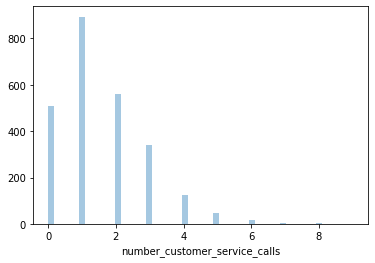

<matplotlib.axes._subplots.AxesSubplot at 0x7f4d7980b750>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

sb.distplot(sample_data['number_customer_service_calls'], kde=False)

We can examine feature differences in the distribution of our features when we condition (split) our data in whether they churned or not.

[BoxPlot docs](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.boxplot.html)

Out[17]:

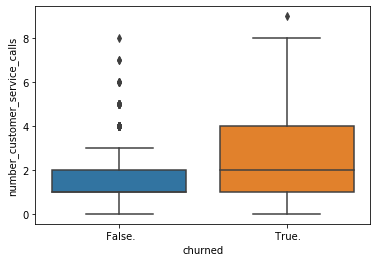

<matplotlib.axes._subplots.AxesSubplot at 0x7f4d78f7dcd0>

In [0]:
sb.boxplot(x="churned", y="number_customer_service_calls", data=sample_data)

## Joint Distributions

Looking at joint distributions of data can also tell us a lot, particularly about redundant features. [Seaborn's PairPlot](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.pairplot.html#seaborn.pairplot) let's us look at joint distributions for many variables at once.

Out[18]:

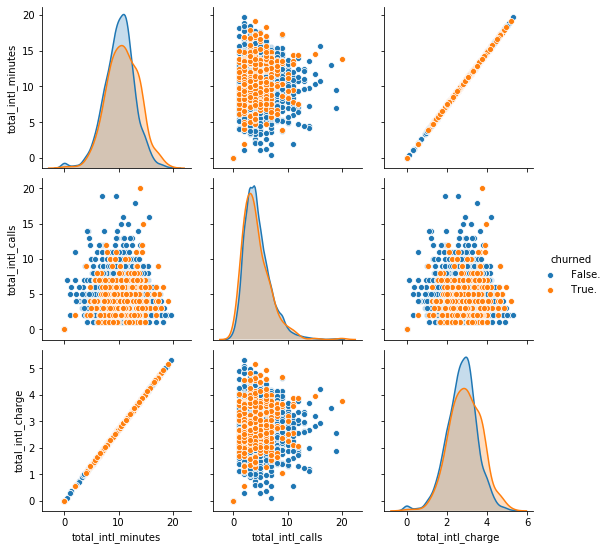

<seaborn.axisgrid.PairGrid at 0x7f4d78ea0dd0>

In [0]:
example_numeric_data = sample_data[["total_intl_minutes", "total_intl_calls",
                                       "total_intl_charge", "churned"]]
sb.pairplot(example_numeric_data, hue="churned")

Clearly, there are some strong linear relationships between some variables, let's get a general impression of the correlations between variables by using [Seaborn's heatmap functionality.](http://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.heatmap.html)

Out[19]:

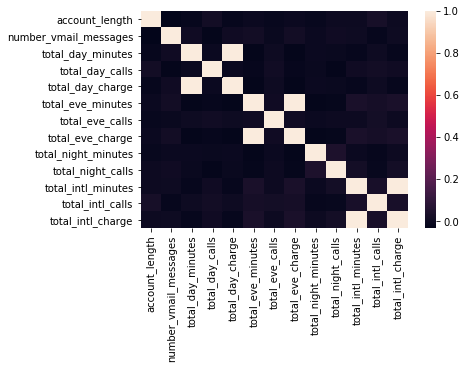

<matplotlib.axes._subplots.AxesSubplot at 0x7f4d78a1ed90>

In [0]:
corr = sample_data[["account_length", "number_vmail_messages", "total_day_minutes",
                    "total_day_calls", "total_day_charge", "total_eve_minutes",
                    "total_eve_calls", "total_eve_charge", "total_night_minutes",
                    "total_night_calls", "total_intl_minutes", "total_intl_calls",
                    "total_intl_charge"]].corr()

sb.heatmap(corr)

Let's generate a pair plot for all numerical variables that we have.

Out[28]:

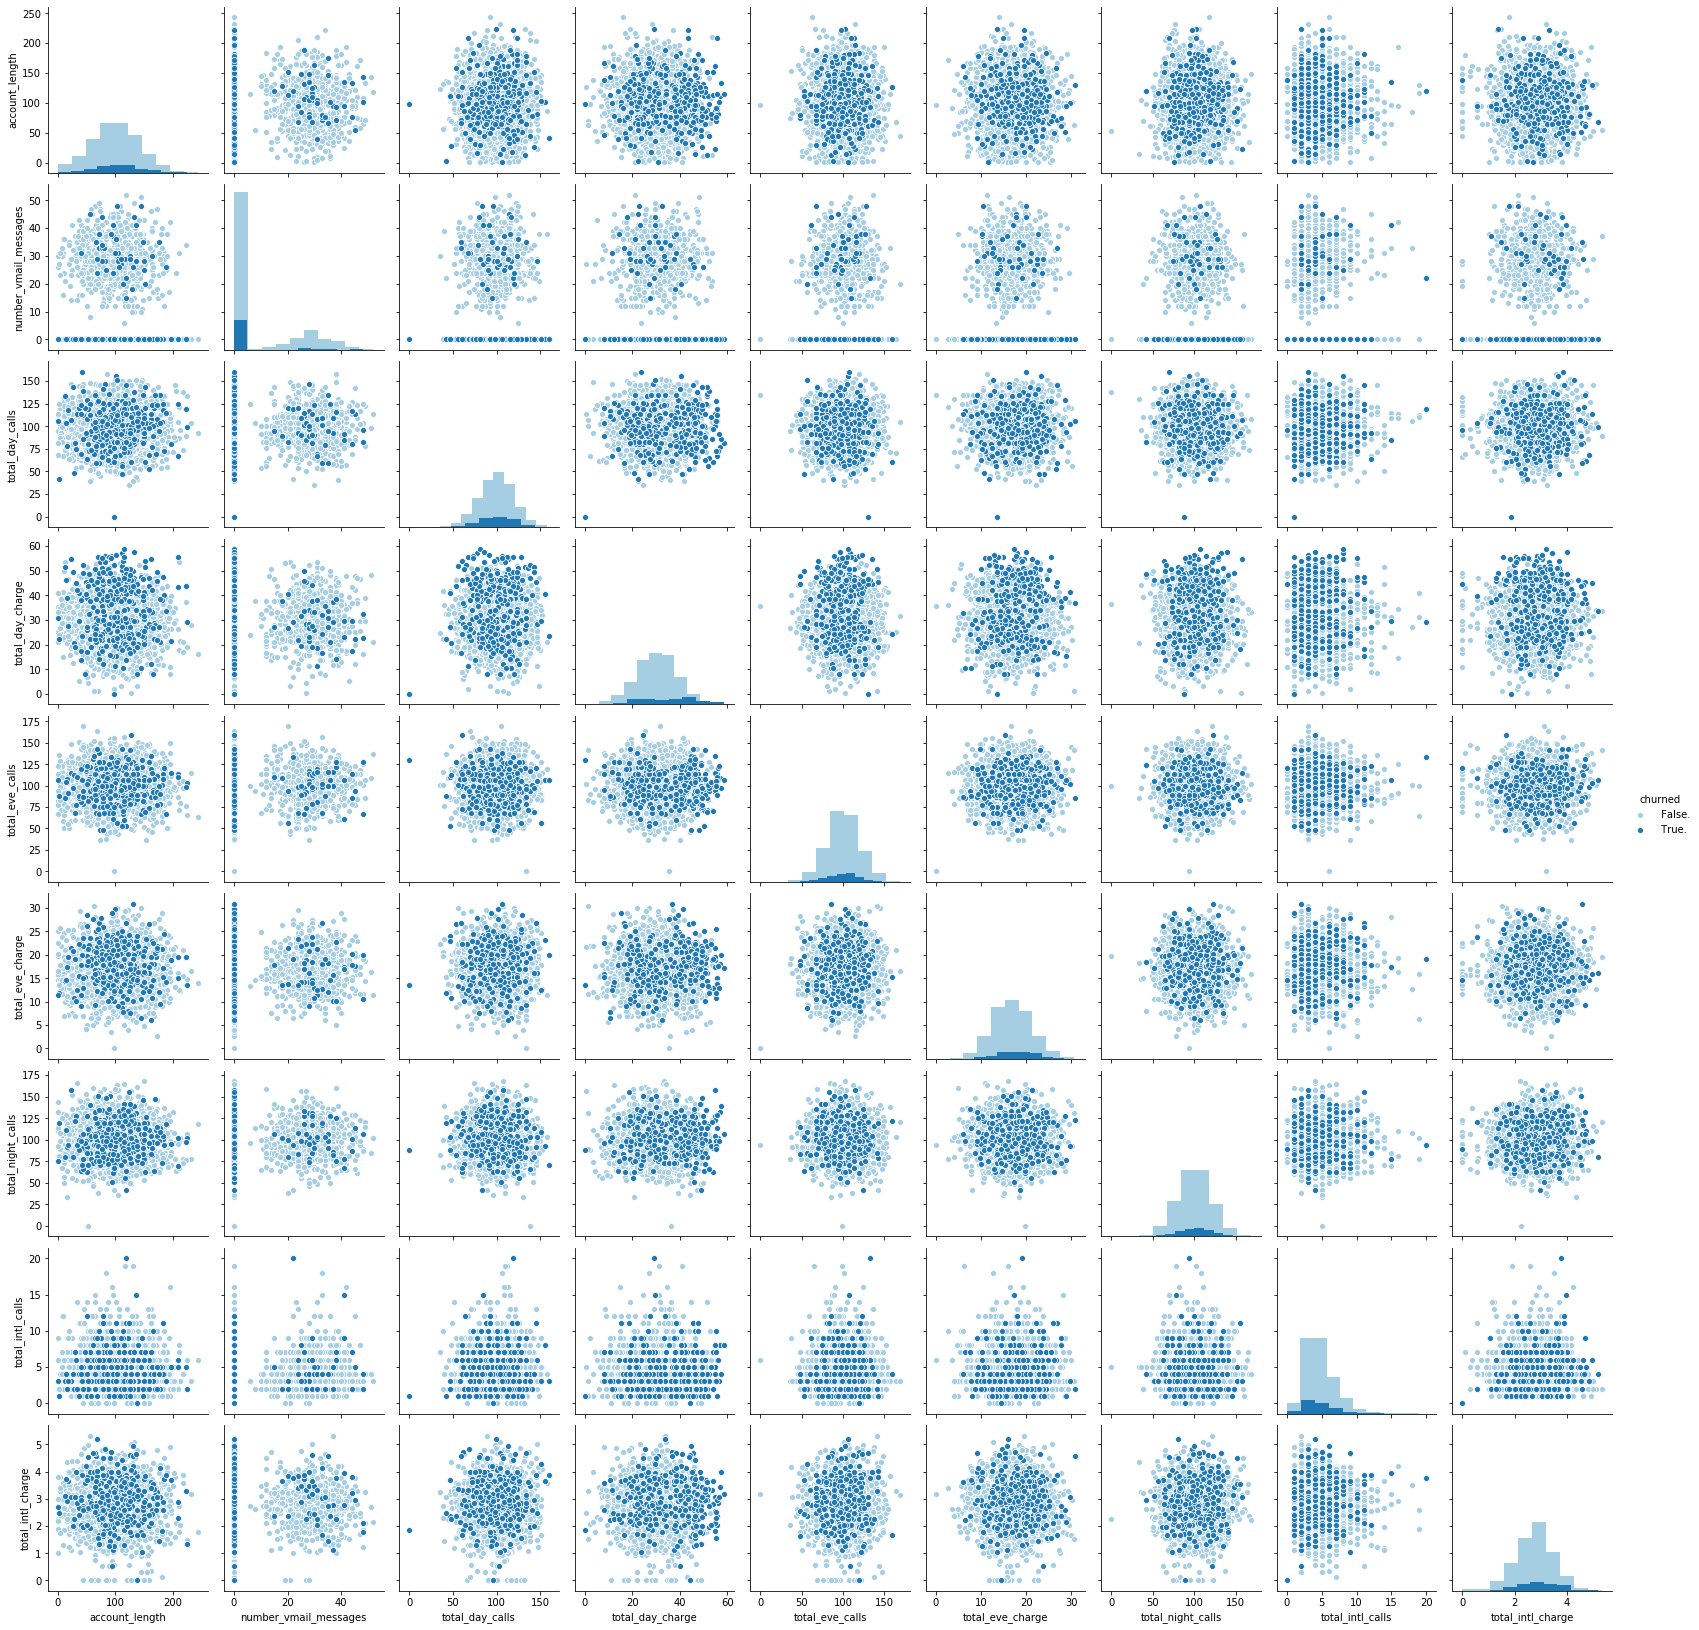

<seaborn.axisgrid.PairGrid at 0x7f4d6e68a650>

In [0]:
reduced_numeric_cols = ["account_length", "number_vmail_messages", "total_day_calls",
                        "total_day_charge", "total_eve_calls", "total_eve_charge",
                        "total_night_calls", "total_intl_calls", "total_intl_charge"]

sb.pairplot(sample_data[reduced_numeric_cols + ['churned']], diag_kind="hist", hue="churned", palette='Paired')

# Build a classification model using MLLib

We want to build a predictive model.

The overall process:

![Model building diagraming showing input data split into train and test data. The training data is aligned with a feature extraction and model training set, which outputs a fitter model. The testing data alignes with a feature extraction, scoring/model application, and model evaluation step.](slides/model flow.png)

# Feature Extraction and Model Training

We need to:
* Code features that are not already numeric
* Gather all features we need into a single column in the DataFrame.
* Split labeled data into training and testing set
* Fit the model to the training data.

## Feature Extraction
We need to define our input features.

[PySpark Pipeline Docs](https://spark.apache.org/docs/1.5.0/api/python/pyspark.ml.html)

In [0]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

label_indexer = StringIndexer(inputCol = 'churned', outputCol = 'label')
plan_indexer = StringIndexer(inputCol = 'intl_plan', outputCol = 'intl_plan_indexed')

assembler = VectorAssembler(
    inputCols = ['intl_plan_indexed'] + reduced_numeric_cols,
    outputCol = 'features')

## Model Training

We can now define our classifier and pipeline. With this done, we can split our labeled data in train and test sets and fit a model.

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

classifier = DecisionTreeClassifier(labelCol = 'label', featuresCol = 'features')

pipeline = Pipeline(stages=[plan_indexer, label_indexer, assembler, classifier])

(train, test) = churn_data.randomSplit([0.7, 0.3])
model = pipeline.fit(train)

## Model Evaluation

The most important question to ask:
    
    Is my predictor better than random guessing?

How do we quantify that?

Measure the area under the ROC curve, abreviated to AUROC.

![example of an roc curve](slides/roc_curve.png)

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = model.transform(test)
evaluator = BinaryClassificationEvaluator()
auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
"The AUROC is %s and the AUPR is %s." % (auroc, aupr)

Out[31]: 'The AUROC is 0.3472616912677611 and the AUPR is 0.10402191726039195.'

# Exercise: Fit a RandomForestClassifier

Fit a random forest classifier to the data. Try experimenting with different values of the `maxDepth`, `numTrees`, and `entropy` parameters to see which gives the best classification performance. Do the settings that give the best classification performance on the training set also give the best classification performance on the test set?

Have a look at the [documentation](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.classification.RandomForestClassifier]documentation).

In [0]:
from pyspark.ml.classification import RandomForestClassifier

# Your code here